# Lab 10 Presentation - Third Competition Round-Up

Erez Buchweitz

# Prepare simulation setup

Here’s how one could approach the competition.

## Load data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
dir_path = r"../datasets/competition_3_diabetes/"
X = pd.read_parquet(f"{dir_path}X_train.parquet")
y = pd.read_parquet(f"{dir_path}y_train.parquet").squeeze()
X.shape, y.shape

((200000, 21), (200000,))

## Cross validation folds

Split randomly into five folds.

In [3]:
nfolds = 5
fold = np.resize(list(range(nfolds)), X.shape[0])
np.random.shuffle(fold)
cv_pairs = [{
    "X_train": X.loc[fold != i,:],
    "y_train": y.loc[fold != i],
    "X_valid": X.loc[fold == i,:],
    "y_valid": y.loc[fold == i],
    } for i in np.unique(fold)
]
[(entry["X_train"].shape[0], entry["X_valid"].shape[0]) for entry in cv_pairs]

[(160000, 40000),
 (160000, 40000),
 (160000, 40000),
 (160000, 40000),
 (160000, 40000)]

## Cross validation workflow

Here is a basic workflow that does:

-   Train model on trainset
-   Tune threshold (how?)
-   Score on validset

In [4]:
from sklearn.metrics import f1_score, precision_recall_curve

def fit_predict_score(X_train, y_train, X_valid, y_valid, model, in_sample=False):
    model.fit(X_train, y_train)
    thresh = find_best_threshold(y_train, predict(model, X_train))
    if in_sample:
        pred = predict(model, X_train) > thresh
        return f1_score(y_train, pred)
    else:
        pred = predict(model, X_valid) > thresh
        return f1_score(y_valid, pred)
    

def predict(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:,1]
    elif hasattr(model, "decision_function"):
        return model.decision_function(X)
    else:
        return model.predict(X)

def find_best_threshold(y, pred):
    precision, recall, thresholds = precision_recall_curve(y, pred)
    f1 = 2 * precision * recall / np.where(precision + recall == 0, 1, precision + recall)
    idx = np.argmax(f1)
    return thresholds[idx]

def cv_workflow(model, **kwargs):
    scores = [fit_predict_score(model=model, **entry, **kwargs) for entry in cv_pairs]
    return np.mean(scores)

## Tuning the threshold

A few options:

-   Tune on trainset (like the code above)
-   Tune on validset (like many of you did)
-   Split thresholdset from trainset and tune on it
-   Treat as any other hyperparameter and train model for each threshold
    value

**Question**: what are the pros and cons of each method?

**Answer**:

-   Tune on trainset - overfitting threshold
-   Tune on validset - biasing the cross validation
-   Tune on thresholdset - fewer observations to train on
-   Retrain for each threshold - computationally intensive

## Test run

Let’s train simple models.

In [5]:
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from datetime import datetime

predictors = {
    "logistic": LogisticRegression(C=10000000000),
    "lasso": Lasso(alpha=0.0001),
    "lda": LinearDiscriminantAnalysis(shrinkage=0, solver="lsqr"),
    "svm": LinearSVC(C=0.00001, dual="auto"),
}
for nm, predictor in predictors.items():
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("predictor", predictor),
    ])
    score = cv_workflow(model)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {nm}={score}")
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] end")

[2025-04-04 12:51:01] logistic=0.4614040229289825
[2025-04-04 12:51:04] lasso=0.45799255247438725
[2025-04-04 12:51:06] lda=0.45804499442409535
[2025-04-04 12:51:11] svm=0.45555107822384766
[2025-04-04 12:51:11] end

**Question**: are these good scores?

**Answer**: the answer is data dependent, on some datasets you cannot do
better than this. Is this one of those datasets?

Add to backlog:

-   Try tuning threshold on thresholdset.

# Tune regularization penalty

Logistic:

In [6]:
predictors = {
    C: LogisticRegression(C=C)
    for C in [1, 100, 1000, 1000000, 1000000, 100000000, 10000000000]
}
for nm, predictor in predictors.items():
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("predictor", predictor),
    ])
    score = cv_workflow(model)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {nm}={score}")
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] end")

[2025-04-04 12:51:13] 1=0.4612578742987442
[2025-04-04 12:51:16] 100=0.4614040229289825
[2025-04-04 12:51:19] 1000=0.4614040229289825
[2025-04-04 12:51:22] 1000000=0.4614040229289825
[2025-04-04 12:51:24] 100000000=0.4614040229289825
[2025-04-04 12:51:27] 10000000000=0.4614040229289825
[2025-04-04 12:51:27] end

SVM:

In [7]:
predictors = {
    C: LinearSVC(C=C, dual="auto")
    for C in [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
}
for nm, predictor in predictors.items():
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("predictor", predictor),
    ])
    score = cv_workflow(model)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {nm}={score}")
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] end")

[2025-04-04 12:51:31] 1e-06=0.4393943583018654
[2025-04-04 12:51:35] 1e-05=0.45555107822384766
[2025-04-04 12:51:40] 0.0001=0.4602461324011517
[2025-04-04 12:51:45] 0.001=0.4601514982969565
[2025-04-04 12:51:50] 0.01=0.46115568232964793
[2025-04-04 12:51:55] 0.1=0.46119812173261154
[2025-04-04 12:52:01] 1=0.4612184250879605
[2025-04-04 12:52:01] end

Lasso:

In [8]:
predictors = {
    alpha: Lasso(alpha=alpha)
    for alpha in [0.00000000001, 0.0000001, 0.000001, 0.0001, 0.0001, 0.001, 0.01, 0.1, 1]
}
for nm, predictor in predictors.items():
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("predictor", predictor),
    ])
    score = cv_workflow(model)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {nm}={score}")
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] end")

[2025-04-04 12:52:05] 1e-11=0.45804499442409535
[2025-04-04 12:52:08] 1e-07=0.45804499442409535
[2025-04-04 12:52:11] 1e-06=0.4580002367039159
[2025-04-04 12:52:13] 0.0001=0.45799255247438725
[2025-04-04 12:52:15] 0.001=0.45753509833651657
[2025-04-04 12:52:17] 0.01=0.4551825718127631
[2025-04-04 12:52:19] 0.1=0.1935941506689048
[2025-04-04 12:52:20] 1=0.0
[2025-04-04 12:52:20] end

LDA:

In [9]:
predictors = {
    shrinkage: LinearDiscriminantAnalysis(shrinkage=shrinkage, solver="lsqr")
    for shrinkage in [i/10 for i in range(11)]
}
for nm, predictor in predictors.items():
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("predictor", predictor),
    ])
    score = cv_workflow(model)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {nm}={score}")
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] end")

[2025-04-04 12:52:22] 0.0=0.45804499442409535
[2025-04-04 12:52:25] 0.1=0.45702907101108553
[2025-04-04 12:52:27] 0.2=0.45600224466717665
[2025-04-04 12:52:29] 0.3=0.4535600149629473
[2025-04-04 12:52:32] 0.4=0.45137167825646324
[2025-04-04 12:52:34] 0.5=0.4481299848718205
[2025-04-04 12:52:36] 0.6=0.4454134544472283
[2025-04-04 12:52:38] 0.7=0.4421960275675084
[2025-04-04 12:52:40] 0.8=0.4397890893151556
[2025-04-04 12:52:42] 0.9=0.43548647043119815
[2025-04-04 12:52:44] 1.0=0.4307984696857252
[2025-04-04 12:52:44] end

# Do we need more expressivity?

Let’s compute losses in and out of sample.

In [10]:
predictors = {
    "logistic": LogisticRegression(C=1),
    "lasso": Lasso(alpha=0.000001),
    "lda": LinearDiscriminantAnalysis(shrinkage=0, solver="lsqr"),
    "svm": LinearSVC(C=0.01, dual="auto"),
}
for nm, predictor in predictors.items():
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("predictor", predictor),
    ])
    score = cv_workflow(model)
    score_in_sample = cv_workflow(model, in_sample=True)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {nm}={score} ({score_in_sample})")
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] end")

[2025-04-04 12:52:50] logistic=0.4612578742987442 (0.4622458870106123)
[2025-04-04 12:52:56] lasso=0.4580002367039159 (0.4591032959852958)
[2025-04-04 12:53:01] lda=0.45804499442409535 (0.4591019048572953)
[2025-04-04 12:53:12] svm=0.46115568232964793 (0.4620955920215676)
[2025-04-04 12:53:12] end

Looks like regularization is not helpful at this point.

## Feature engineering

Let’s look at the features.

In [11]:
{col: str(np.sort(X[col].unique()).tolist()) for col in X.columns}

{'HighBP': '[0, 1]',
 'HighChol': '[0, 1]',
 'CholCheck': '[0, 1]',
 'BMI': '[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 95, 96, 98]',
 'Smoker': '[0, 1]',
 'Stroke': '[0, 1]',
 'HeartDiseaseorAttack': '[0, 1]',
 'PhysActivity': '[0, 1]',
 'Fruits': '[0, 1]',
 'Veggies': '[0, 1]',
 'HvyAlcoholConsump': '[0, 1]',
 'AnyHealthcare': '[0, 1]',
 'NoDocbcCost': '[0, 1]',
 'GenHlth': '[1, 2, 3, 4, 5]',
 'MentHlth': '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]',
 'PhysHlth': '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]',
 'DiffWalk': '[0, 1]',
 'Sex': '[0, 1]',
 'Age': '[1, 2, 3, 4,

There appear to be some numeric features, and most of the rest are
binary. Let’s create lists of each kind.

In [12]:
features_binary = [col for col in X.columns if X[col].nunique() == 2]
features_numeric = [col for col in X.columns if X[col].nunique() > 2]
features_numeric, features_binary

(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income'],
 ['HighBP',
  'HighChol',
  'CholCheck',
  'Smoker',
  'Stroke',
  'HeartDiseaseorAttack',
  'PhysActivity',
  'Fruits',
  'Veggies',
  'HvyAlcoholConsump',
  'AnyHealthcare',
  'NoDocbcCost',
  'DiffWalk',
  'Sex'])

## Numeric features

### Quantile plot for logistic regression

Here is a variant of quantile plot for logistic regression, that applies
logistic transform to the mean `y` values. Remember that logistic
regression assumes: $$
\log\left(\frac{p}{1-p}\right) = \boldsymbol{x}^T\boldsymbol{\beta}
$$ where $p=\mathbb{P}(y=1|\boldsymbol{x})$.

So we will apply the same transformation to the average $y$ values in
each bin, and we’ll want to make like transformed line as linear as
possible.

In [13]:
def quantile_plot(x, y, by=None, bins=10, by_bins=3, y_fn=lambda x: x):
    assert len(x) == len(y)

    def qp_data(x, y):
        fac = np.searchsorted(np.quantile(x, q=[i / bins for i in range(1, bins)]), x)
        ufac = np.unique(fac)
        qx = np.array([np.mean(x[fac == f]) for f in ufac])
        qy = np.array([y_fn(np.mean(y[fac == f])) for f in ufac])
        return qx, qy

    qx, qy = qp_data(x, y)
    if by is None:
        plt.plot(qx, qy, "-o")
    else:
        assert len(x) == len(by)
        plt.plot(qx, qy, "-o", label="ALL", color="lightgrey")
        by_fac = np.searchsorted(np.quantile(by, q=[i / by_bins for i in range(1, by_bins)]), by)
        by_ufac = np.unique(by_fac)
        for i, f in enumerate(np.unique(by_ufac)):
            mask = by_fac == f
            nm = f"{i}) {min(by[mask]):.2f} / {max(by[mask]):.2f}"
            qx, qy = qp_data(x[mask], y[mask])
            plt.plot(qx, qy, "-o", label=nm)
        plt.legend()

def quantile_plot_logistic(*args, **kwargs):
    quantile_plot(*args, y_fn=lambda x: np.log(x / (1 - x)), **kwargs)

Now to plot all numeric features:

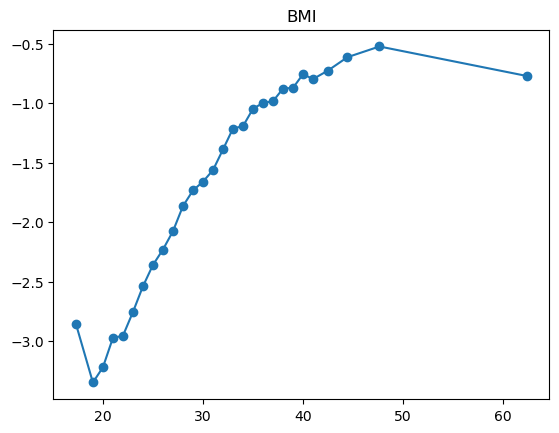

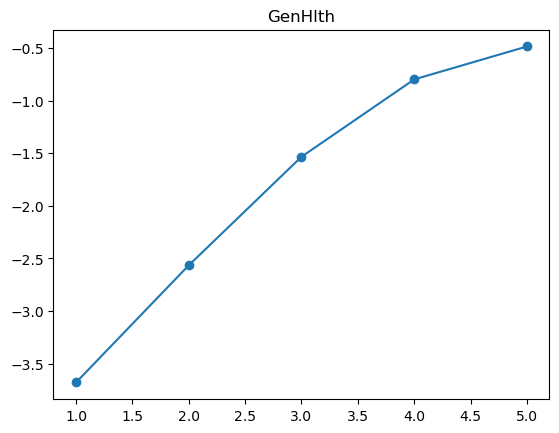

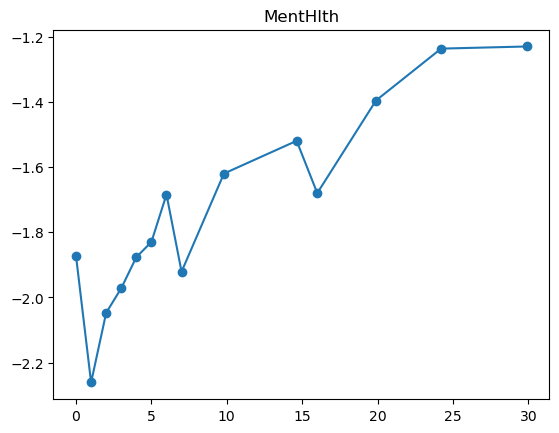

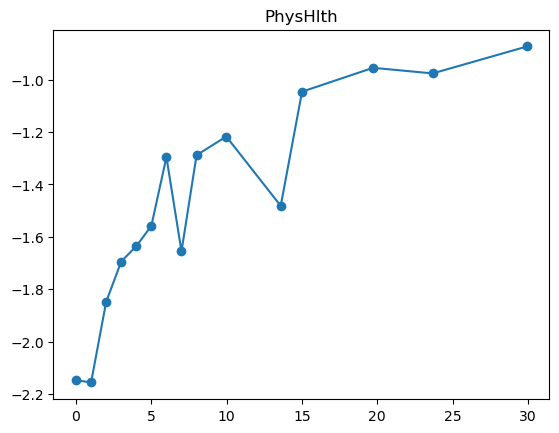

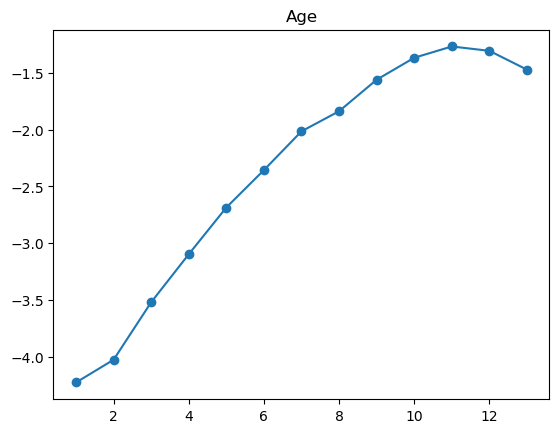

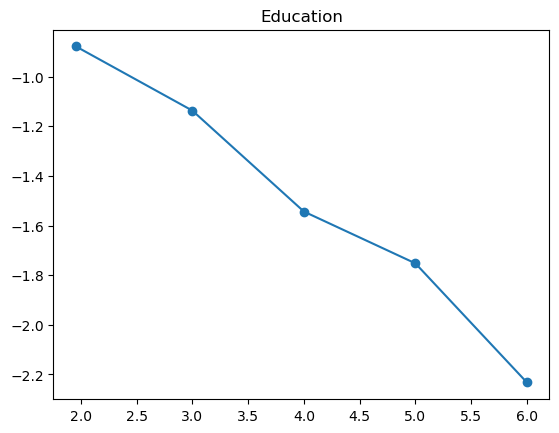

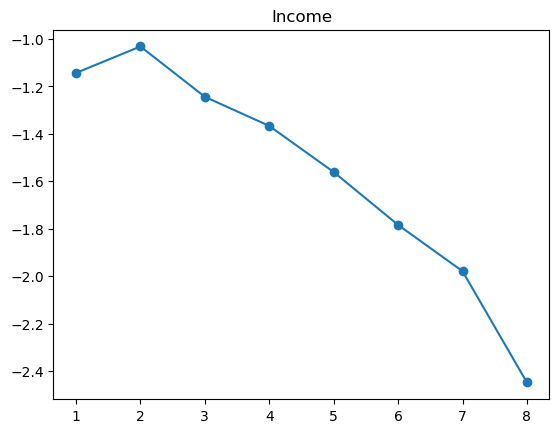

In [14]:
for feature in features_numeric:
    plt.figure()
    quantile_plot_logistic(X[feature], y, bins=100)
    plt.title(feature)
    plt.show()

For some of the features (BMI, age, income), the shape looks completely
believable (remember we have lots of data). We might be tempted to just
throw in a very expressive transformation, say cubic spline with 20
knots, and see what happens. Let’s try that.

### Expressive transformation to numeric features

In [ ]:
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import ColumnTransformer

predictors = {
    "logistic": LogisticRegression(C=1),
    "lasso": Lasso(alpha=0.01),
    "lda": LinearDiscriminantAnalysis(shrinkage=0, solver="lsqr"),
    "svm": LinearSVC(C=0.01, dual="auto"),
}
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] end")
for nm, predictor in predictors.items():
    transformer_numeric = Pipeline(steps=[
        ('spline', SplineTransformer(degree=3, n_knots=20)),
        ('scaler', StandardScaler())
    ])
    transformer_binary = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', transformer_numeric, features_numeric),
            ('binary', transformer_binary, features_binary)
        ]
    )
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("predictor", predictor),
    ])
    score = cv_workflow(model)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {nm}={score}")
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] end")


[2025-04-04 12:53:42] logistic=0.4690488043555326
[2025-04-04 12:54:10] lasso=0.45330544429073233
[2025-04-04 12:54:35] lda=0.459476711550418
[2025-04-04 12:56:30] svm=0.4674114099163023
[2025-04-04 12:56:30] end

Number of features:

In [16]:
len(model.named_steps['preprocessor'].get_feature_names_out())

168

Add to backlog:

-   Less expressive transformation for features that don’t appear to
    deserve it.
-   Add interactions.

## Binary features

Any transformation to a binary feature is an affine transformation,
which doesn’t affect a linear model (apart from possibly penalizing the
feature differently).

Let’s try to add interactions and see what happens.

In [20]:
from sklearn.preprocessing import PolynomialFeatures

predictors = {
    "logistic": LogisticRegression(C=1),
    #"lasso": Lasso(alpha=0.01),
    "lda": LinearDiscriminantAnalysis(shrinkage=0, solver="lsqr"),
    "svm": LinearSVC(C=0.01, dual="auto"),
}
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] start")
for nm, predictor in predictors.items():
    transformer_numeric = Pipeline(steps=[
        ('spline', SplineTransformer(degree=3, n_knots=20)),
        ('scaler', StandardScaler())
    ])
    transformer_binary = Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', transformer_numeric, features_numeric),
            ('binary', transformer_binary, features_binary)
        ]
    )
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("predictor", predictor),
    ])
    score = cv_workflow(model)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {nm}={score}")
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] end")

[2025-04-04 13:50:03] start
[2025-04-04 13:50:49] logistic=0.47084598935372934
[2025-04-04 13:51:10] lda=0.46446677312539686
[2025-04-04 13:53:34] svm=0.46995657867346646
[2025-04-04 13:53:34] end

# Retune regularization

In [22]:
predictors = {
    C: LinearSVC(C=C, dual="auto")
    for C in [0.000001, 0.00001, 0.0001, 0.001, 0.01]
}
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] start")
for nm, predictor in predictors.items():
    transformer_numeric = Pipeline(steps=[
        ('spline', SplineTransformer(degree=3, n_knots=20)),
        ('scaler', StandardScaler())
    ])
    transformer_binary = Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', transformer_numeric, features_numeric),
            ('binary', transformer_binary, features_binary)
        ]
    )
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("predictor", predictor),
    ])
    score = cv_workflow(model)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {nm}={score}")
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] end")

[2025-04-04 13:54:11] start
[2025-04-04 13:54:36] 1e-06=0.4544754791334615
[2025-04-04 13:55:14] 1e-05=0.4630177566185475
[2025-04-04 13:56:07] 0.0001=0.4671811106134466
[2025-04-04 13:57:47] 0.001=0.46953948020749225
[2025-04-04 14:00:12] 0.01=0.46995657867346646
[2025-04-04 14:00:12] end

Interactions for binary features helps slightly, but this increases
running time. Regularization is still not needed Number of features:

In [23]:
len(model.named_steps['preprocessor'].get_feature_names_out())

259

# Ensembling

Let’s try averaging the three models. First, define the models.

In [24]:
predictors = {
    "logistic": LogisticRegression(C=1),
    "lasso": Lasso(alpha=0.1),
    "lda": LinearDiscriminantAnalysis(shrinkage=0, solver="lsqr"),
    "svm": LinearSVC(C=0.01, dual="auto"),
}
transformer_numeric = Pipeline(steps=[
    ('spline', SplineTransformer(degree=3, n_knots=20)),
    ('scaler', StandardScaler())
])
transformer_binary = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', transformer_numeric, features_numeric),
        ('binary', transformer_binary, features_binary)
    ]
)
models = {
    nm: Pipeline([
        ("preprocessor", preprocessor),
        ("predictor", predictor),
    ])
    for nm, predictor in predictors.items()
}

Single train-valid-test split.

In [25]:
X_train, y_train, X_valid, y_valid = cv_pairs[0]["X_train"], cv_pairs[0]["y_train"], cv_pairs[0]["X_valid"], cv_pairs[0]["y_valid"]

In [27]:
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] start")
for nm, model in models.items():
    model.fit(X_train, y_train)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {nm}")
print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] end")

[2025-04-04 14:02:26] start
[2025-04-04 14:02:33] logistic
[2025-04-04 14:02:36] lasso
[2025-04-04 14:02:39] lda
[2025-04-04 14:03:08] svm
[2025-04-04 14:03:08] end

In [30]:
preds = {nm: predict(model, X_train) for nm, model in models.items()}
locs = {nm: pred.mean() for nm, pred in preds.items()}
scales = {nm: pred.std() for nm, pred in preds.items()}
preds_normalized = {nm: (pred - locs[nm]) / scales[nm] for nm, pred in preds.items()}
preds_valid_normalized = {nm: (predict(model, X_valid) - locs[nm]) / scales[nm] for nm, model in models.items()}

In [ ]:
from itertools import product
from functools import reduce
nms = list(models.keys())
grid = product(*[[i/10 for i in range(11)] for nm in models])
scores = []
for wt in grid:
    if sum(wt) != 1:
        continue
    pred = reduce(lambda x, y: x+y, (preds_normalized[nm] * wt[i] for i, nm in enumerate(nms)), 0)
    thresh = find_best_threshold(y_train, pred)
    pred_valid = reduce(lambda x, y: x+y, (preds_valid_normalized[nm] * wt[i] for i, nm in enumerate(nms)), 0)
    scores.append({
        "wt": wt,
        "f1": f1_score(y_valid, pred_valid > thresh)
    })
scores

In [ ]:
best_wt = max(scores, key=lambda x: x['f1'])
best_wt